# 1 Punto

ganancia: 1.0


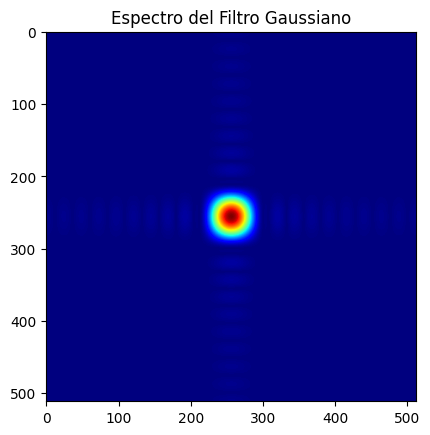

(<matplotlib.image.AxesImage at 0x7ae03140ca00>,
 Text(0.5, 1.0, 'Espectro del Filtro Gaussiano'),
 None)

In [30]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display, HTML


def create_gauss_filter(h, w, k_size, sigma):
    """
    Parámetros:
    - h: Altura de la imagen.
    - w: Ancho de la imagen.
    - k_size: Tamaño del kernel gaussiano (modificable para el TPII)
    - sigma: Desviación estándar del gaussiano (modificable para el TPII)
    """
    gauss_kernel_1d = cv2.getGaussianKernel(k_size, sigma, cv2.CV_32F)
    gauss_kernel_2d = gauss_kernel_1d * gauss_kernel_1d.T
    print(f'ganancia: {np.sum(gauss_kernel_2d)}')

    padded_kernel = np.zeros((h, w), dtype=np.float32)
    kh, kw = gauss_kernel_2d.shape
    padded_kernel[:kh, :kw] = gauss_kernel_2d


    dft_kernel = cv2.dft(np.float32(padded_kernel), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_kernel_shift = np.fft.fftshift(dft_kernel)

    return dft_kernel_shift

### funciones auxiliares ###

def fft2_mod(image):
  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))
  return 20*np.log(np.abs(shifted_image_fft))

def _filter_round_shape(height, width, radius):
  canvas = np.zeros((height, width))
  return cv2.circle(canvas,
                     center=(int(canvas.shape[1]/2), int(canvas.shape[0]/2)),
                     radius=radius,
                     color=(255),
                     thickness=-1).astype(np.uint8)

def create_lp_filter(height, width, radius=20):
  lp_filter = _filter_round_shape(height, width, radius)
  return lp_filter


def create_hp_filter(height, width, radius=60):
  lp_filter = _filter_round_shape(height, width, radius)
  return cv2.bitwise_not(lp_filter)

h, w = 512, 512  # Dimensiones de la imagen (o del filtro deseado)
k_size = 21  # Tamaño del kernel
sigma = 5    # Desviación estándar del gaussiano

gauss_filter_fft = create_gauss_filter(h, w, k_size, sigma)

# Visualizar la magnitud del espectro del filtro gaussiano
magnitude_spectrum = 20 * np.log(cv2.magnitude(gauss_filter_fft[:, :, 0], gauss_filter_fft[:, :, 1]) + 1)
plt.imshow(magnitude_spectrum, cmap='jet'), plt.title('Espectro del Filtro Gaussiano'), plt.show()


ganancia: 1.0000001192092896
ganancia: 1.0
ganancia: 1.0
ganancia: 1.0


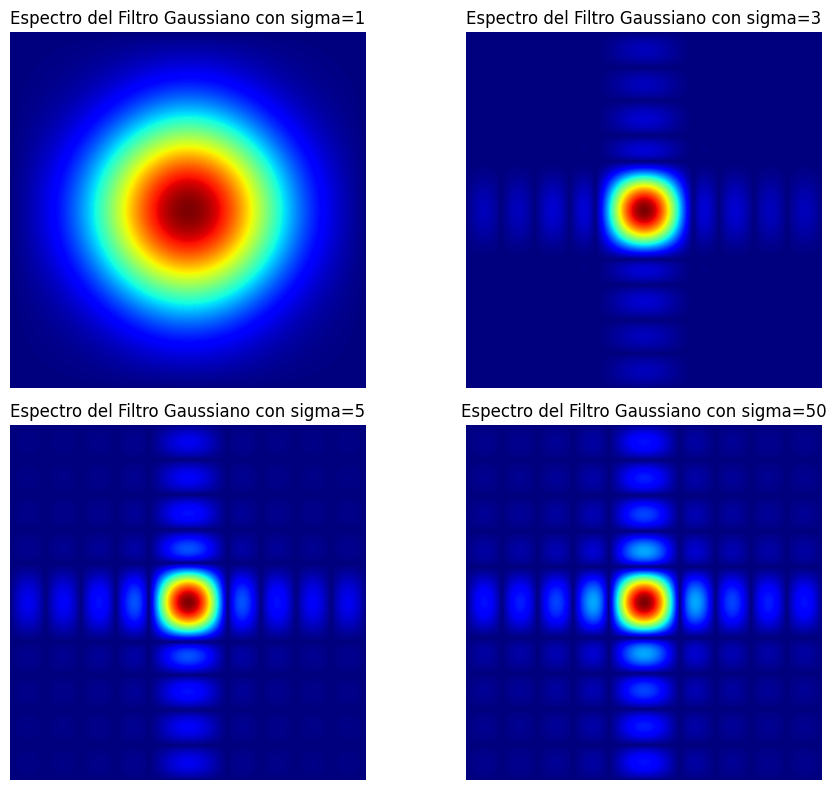

In [25]:
# Definimos las dimensiones del filtro y el tamaño del kernel
h, w = 512, 512  # Dimensiones de la imagen (o del filtro deseado)
k_size = 10  # Tamaño del kernel

# Definimos los cuatro valores diferentes de sigma para testear (requerimientos punto)
sigmas = [1, 3, 5, 50]

# Creamos una figura para los plots
plt.figure(figsize=(10, 8))

# Iteramos sobre los valores de sigma
for i, sigma in enumerate(sigmas, 1):
    # Creamos el filtro gaussiano en el dominio de la frecuencia para cada sigma
    gauss_filter_fft = create_gauss_filter(h, w, k_size, sigma)

    # Calculamos la magnitud del espectro del filtro gaussiano
    magnitude_spectrum = 20 * np.log(cv2.magnitude(gauss_filter_fft[:, :, 0], gauss_filter_fft[:, :, 1]) + 1)

    # Visualizamos la magnitud del espectro del filtro gaussiano
    plt.subplot(2, 2, i)
    plt.imshow(magnitude_spectrum, cmap='jet')
    plt.title(f'Espectro del Filtro Gaussiano con sigma={sigma}')
    plt.axis('off')

# Mostramos todas las visualizaciones juntas
plt.tight_layout()
plt.show()


ganancia: 0.9999999403953552
ganancia: 1.0
ganancia: 1.0
ganancia: 1.0


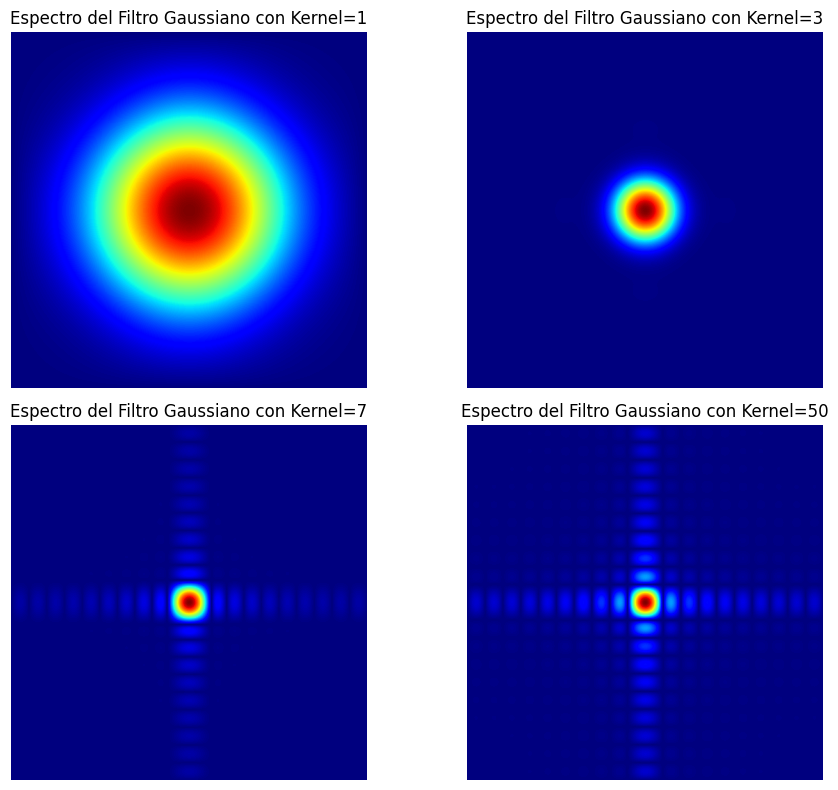

In [20]:
# Definimos las dimensiones del filtro y el tamaño del Sigma
h, w = 512, 512  # Dimensiones de la imagen (o del filtro deseado)
sigma = 20  # Tamaño del sigma

# Definimos los cuatro valores diferentes de kernel para testear
k_size = [1, 3, 7, 50]

# Creamos una figura para los plots
plt.figure(figsize=(10, 8))

# Iteramos sobre los valores de sigma
for i, k_size in enumerate(k_size, 1):
    # Creamos el filtro gaussiano en el dominio de la frecuencia para cada sigma
    gauss_filter_fft = create_gauss_filter(h, w, sigma,k_size)

    # Calculamos la magnitud del espectro del filtro gaussiano
    magnitude_spectrum = 20 * np.log(cv2.magnitude(gauss_filter_fft[:, :, 0], gauss_filter_fft[:, :, 1]) + 1)

    # Visualizamos la magnitud del espectro del filtro gaussiano
    plt.subplot(2, 2, i)
    plt.imshow(magnitude_spectrum, cmap='jet')
    plt.title(f'Espectro del Filtro Gaussiano con Kernel={k_size}')
    plt.axis('off')

# Mostramos todas las visualizaciones juntas
plt.tight_layout()
plt.show()

ganancia: 0.9999999403953552


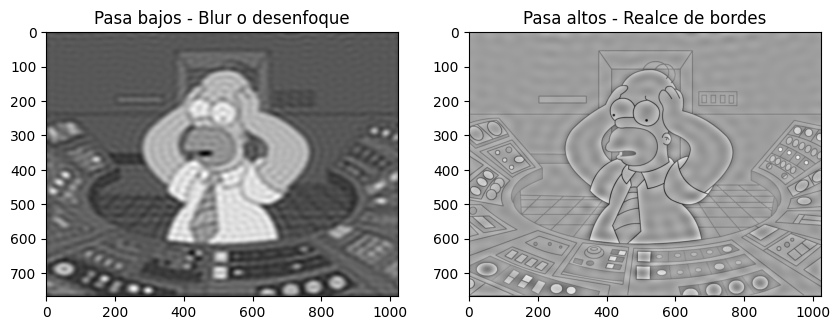

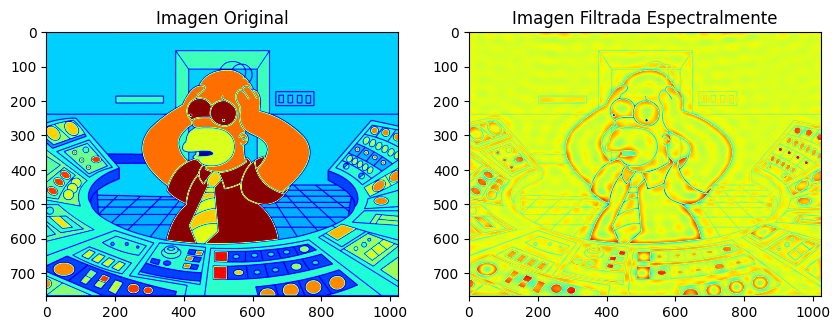

In [46]:
def apply_filter_in_frequency_domain(image, filter_fft):

    lp_filter = create_lp_filter(h, w, radius=40)
    hp_filter = create_hp_filter(h, w, radius=20)

    shifted_fft = np.fft.fftshift(np.fft.fft2(image))
    lp_filtered = shifted_fft * lp_filter
    hp_filtered = shifted_fft * hp_filter

    # Aplicamos la antitransformada y obtenemos las imagenes filtradas
    f_ishift = np.fft.ifftshift(lp_filtered)
    img_lp = np.real(np.fft.ifft2(f_ishift))
    f_ishift = np.fft.ifftshift(hp_filtered)
    img_hp = np.real(np.fft.ifft2(f_ishift))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img_lp, cmap='gray')
    plt.title('Pasa bajos - Blur o desenfoque')
    plt.subplot(1,2,2)
    plt.title('Pasa altos - Realce de bordes')
    plt.imshow(img_hp, cmap='gray')

    return img_hp

# Cargar imagen
image_path = '/content/homer-2-1531586001.jpg'  # Imagen de mi computador personal
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen desde {image_path}")
h, w = image.shape

# Configuración del filtro
k_size = 3  # Tamaño del kernel gaussiano
sigma = 5    # Desviación estándar del gaussiano

# Crear el filtro gaussiano y aplicarlo en el dominio de la frecuencia
filter_fft = create_gauss_filter(h, w, k_size, sigma)
filtered_image = apply_filter_in_frequency_domain(image, filter_fft)

# Visualización de la imagen original y la imagen filtrada
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image,cmap='jet'), plt.title('Imagen Original')
plt.subplot(122), plt.imshow(filtered_image,cmap='jet'), plt.title('Imagen Filtrada Espectralmente')

plt.show()

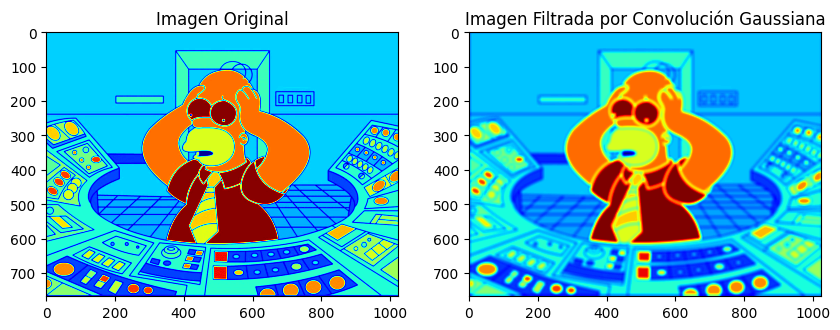

In [29]:
def apply_gaussian_blur_convolution(image, k_size, sigma):
    # Obtener el kernel gaussiano en el dominio espacial, no en el dominio de la frecuencia
    gauss_kernel_1d = cv2.getGaussianKernel(k_size, sigma)
    gauss_kernel_2d = gauss_kernel_1d * gauss_kernel_1d.T

    # Aplicar el filtrado por convolución usando el kernel gaussiano
    filtered_image = cv2.filter2D(image, -1, gauss_kernel_2d)

    return filtered_image

# Cargar una imagen real
image_path = '/content/homer-2-1531586001.jpg'  # Reemplaza esto con la ruta a tu imagen
image2 = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image2 is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen desde {image_path}")

# Aplicar el filtro gaussiano a la imagen mediante convolución
k_size = 15  # Tamaño del kernel
sigma = 5    # Desviación estándar del gaussiano
filtered_image2 = apply_gaussian_blur_convolution(image, k_size, sigma)

# Mostrar la imagen original y la imagen filtrada
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image, cmap='jet'), plt.title('Imagen Original')
plt.subplot(122), plt.imshow(filtered_image2, cmap='jet'), plt.title('Imagen Filtrada por Convolución Gaussiana')
plt.show()

# 2 Punto

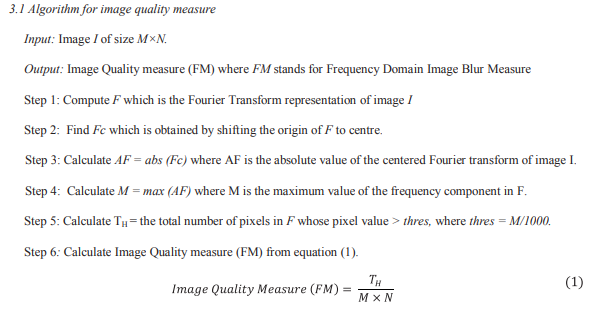

In [32]:
import numpy as np
import cv2

def calculate_image_quality_measure(image):
    dft_image = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_image_shift = np.fft.fftshift(dft_image)
    magnitude_spectrum = cv2.magnitude(dft_image_shift[:, :, 0], dft_image_shift[:, :, 1])
    M = np.max(magnitude_spectrum)
    thres = M / 1000.0
    TH = np.sum(magnitude_spectrum > thres)
    FM = TH / (image.shape[0] * image.shape[1])
    return FM


image_path = '/content/homer-2-1531586001.jpg'  # Imagen personal
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen desde {image_path}")

# Calcular la medida de calidad de imagen
image_quality_measure = calculate_image_quality_measure(filtered_image)
image_quality_measure2 = calculate_image_quality_measure(filtered_image2)

# Datos a imprimir
datos = {"Medida de Calidad de la Imagen (FM) - Filtro Espectral": image_quality_measure,"Medida de Calidad de la Imagen (FM) - Filtro Convolucion Gaussiana": image_quality_measure2}

        # Convertir los datos a HTML
html = "<div style='border: 1px solid black; padding: 10px;'>"
for key, value in datos.items():
   html += f"<p><b>{key}:</b> {value}</p>"
html += "</div>"

        # Mostrar los datos en un cuadro
display(HTML(html))


# 3 Punto

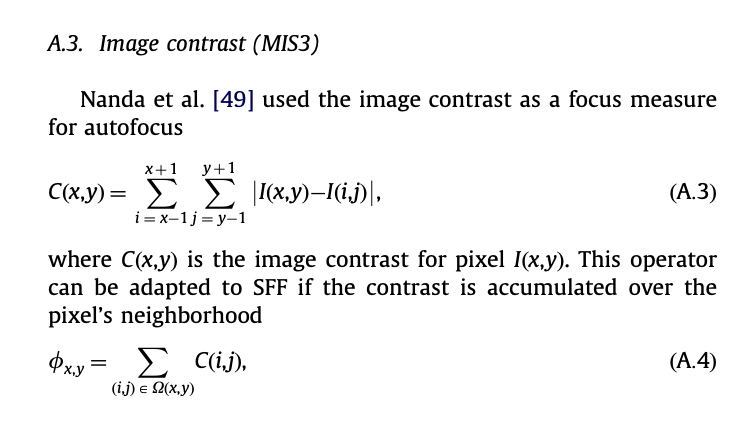

In [36]:
def calculate_contrast(image):
    # Convertir a escala de grises si la imagen es a color
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convertir la imagen a tipo de dato flotante para hacer las operaciones
    image_float = image.astype(np.float32)

    # Preparar la imagen de salida para el contraste
    contrast_image = np.zeros_like(image_float)

    # Calcular el contraste para cada píxel
    for x in range(1, image.shape[0] - 1):
        for y in range(1, image.shape[1] - 1):
            local_sum = 0
            for i in range(-1, 2):
                for j in range(-1, 2):
                    local_sum += np.abs(image_float[x, y] - image_float[x + i, y + j])
            contrast_image[x, y] = local_sum

    # Sumar el contraste en la vecindad de cada píxel
    phi = np.zeros_like(contrast_image)
    for x in range(1, image.shape[0] - 1):
        for y in range(1, image.shape[1] - 1):
            phi[x, y] = np.sum(contrast_image[x-1:x+2, y-1:y+2])

    return phi

def calculate_image_quality_measure(image):
    image_contrast = calculate_contrast(image)
    # Calcular el valor numérico de la medida de calidad de la imagen
    quality_measure = np.mean(image_contrast)
    return quality_measure

# Calcular la medida de calidad de la imagen para ambas imágenes filtradas
image_quality_measure_ic_value = calculate_image_quality_measure(filtered_image)
image_quality_measure2_ic_value = calculate_image_quality_measure(filtered_image2)


image_quality_measure_ic = calculate_contrast(filtered_image)
image_quality_measure2_ic = calculate_contrast(filtered_image2)

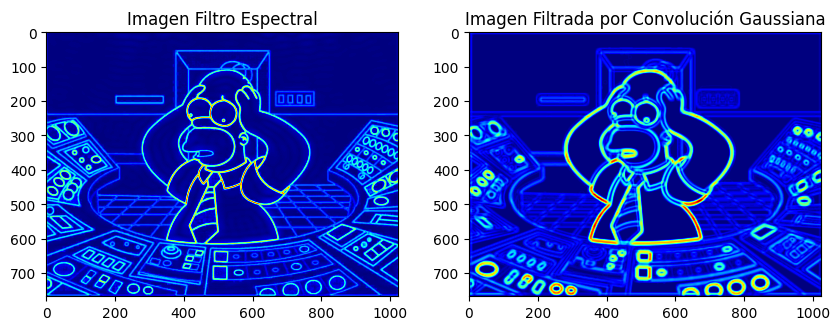

In [43]:
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image_quality_measure_ic, cmap='jet'), plt.title('Imagen Filtro Espectral')
plt.subplot(122), plt.imshow(image_quality_measure2_ic, cmap='jet'), plt.title('Imagen Filtrada por Convolución Gaussiana')
plt.show()

In [45]:
# Datos a imprimir
datos = {"Medida de Contraste de la Imagen (MIS3) - Filtro Espectral": image_quality_measure_ic_value,"Medida de Contraste de la Imagen (MIS3) - Filtro Convolucion Gaussiana": image_quality_measure2_ic_value}

        # Convertir los datos a HTML
html = "<div style='border: 1px solid black; padding: 10px;'>"
for key, value in datos.items():
   html += f"<p><b>{key}:</b> {value}</p>"
html += "</div>"

      # Mostrar los datos en un cuadro
display(HTML(html))
